In [ ]:
# Installing Packages
!pip install pyspark

In [ ]:
# Importing Packages
from google.colab import drive
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import StringType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col
import numpy as np
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Estimator
from scipy import stats
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
from pyspark.ml.clustering import KMeans
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import geopandas as gpd
import plotly.express as px

In [ ]:
# Mounting Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Creating spark session
spark = SparkSession.builder.appName("Project_3").getOrCreate()

In [ ]:
# Creating merged_df
jan = spark.read.parquet("/content/drive/MyDrive/Project 3/yellow_tripdata_2018-01.parquet")
feb = spark.read.parquet("/content/drive/MyDrive/Project 3/yellow_tripdata_2018-02.parquet")
mar = spark.read.parquet("/content/drive/MyDrive/Project 3/yellow_tripdata_2018-03.parquet")
apr = spark.read.parquet("/content/drive/MyDrive/Project 3/yellow_tripdata_2018-04.parquet")
may = spark.read.parquet("/content/drive/MyDrive/Project 3/yellow_tripdata_2018-05.parquet")
jun = spark.read.parquet("/content/drive/MyDrive/Project 3/yellow_tripdata_2018-06.parquet")

merged_df = jan.union(feb).union(mar).union(apr).union(may).union(jun)
merged_df.show(10)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       1| 2018-01-01 00:21:05|  2018-01-01 00:24:23|              1|          0.5|         1|                 N|          41|          24|           2|        4.5|  0.5|    0.5|       0.

#### 1)Identify regions in the city with high demand for taxis. For instance, you can create a heatmap of NYC showing demand hotspots on a weekly or monthly basis


In [ ]:
# Creating a function to get datetime information
def datetime_conversion(df, col, prefix):
    return df.withColumn(prefix+"_year", F.year(col)) \
             .withColumn(prefix+"_month", F.month(col)) \
             .withColumn(prefix+"_day", F.dayofmonth(col)) \
             .withColumn(prefix+"_hour", F.hour(col))\
             .withColumn(prefix+"_minute", F.minute(col)) \
             .withColumn(prefix+"_second", F.second(col)) \
             .withColumn(prefix+"_day_of_week", F.dayofweek(col))

In [ ]:
# Updating Dataframe
q1_df = datetime_conversion(merged_df, merged_df.tpep_pickup_datetime, "pickup")
q1_df = datetime_conversion(merged_df, merged_df.tpep_dropoff_datetime, "dropoff")
q1_df = q1_df.withColumn("trip_duration_seconds", F.unix_timestamp("tpep_dropoff_datetime") - F.unix_timestamp("tpep_pickup_datetime"))
q1_df.show(10)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------+-------------+-----------+------------+--------------+--------------+-------------------+---------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|dropoff_year|dropoff_month|dropoff_day|dropoff_hour|dropoff_minute|dropoff_second|dropoff_day_of_week|trip_duration_seconds|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+--------

In [ ]:
# Filtering Dataframe
q1_df = q1_df.withColumn("pickup_week", F.weekofyear("tpep_pickup_datetime")) \
             .withColumn("pickup_month", F.month("tpep_pickup_datetime"))
pickup_counts = q1_df.groupBy("PULocationID", "pickup_week") \
                     .agg(F.count("*").alias("pickup_count"))
pickup_counts_df = pickup_counts.toPandas()

In [ ]:
# Creating longitue and latitude features
gdf = gpd.read_file("/content/drive/MyDrive/Project 3/taxi_zones/taxi_zones.shp")
gdf = gdf.set_crs("EPSG:2263", allow_override=True)
gdf = gdf.to_crs("EPSG:4326")
gdf['latitude'] = gdf.geometry.centroid.y
gdf['longitude'] = gdf.geometry.centroid.x
taxi_zones_df = gdf[['LocationID', 'borough', 'latitude', 'longitude']]

<ipython-input-31-2b12f22f6792>:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['latitude'] = gdf.geometry.centroid.y
<ipython-input-31-2b12f22f6792>:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['longitude'] = gdf.geometry.centroid.x


In [ ]:
# Scaling data
pickup_df = pickup_counts_df.merge(taxi_zones_df, left_on="PULocationID", right_on="LocationID", how="left")
pickup_df = pickup_df.dropna(subset=['latitude', 'longitude', 'pickup_count'])
scaler = StandardScaler()
scaled_data = scaler.fit_transform(pickup_df[['latitude', 'longitude', 'pickup_count']])

In [ ]:
# Mapping Data
eps_value = 0.3
min_samples_value = 15
dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
pickup_df['dbscan_cluster'] = dbscan.fit_predict(scaled_data)
fig_dbscan = px.scatter_mapbox(
    pickup_df, lat='latitude', lon='longitude', color='dbscan_cluster',
    size='pickup_count', zoom=10, mapbox_style="carto-positron",
    title="Taxi Demand Clusters with DBSCAN"
)
fig_dbscan.show()

The code identifies high-demand taxi regions in NYC by analyzing pickup data. It converts timestamps to extract detailed datetime features and calculates weekly pickup counts for each location. The taxi zone data is merged to add geographic information, including latitude and longitude. After scaling the data, it uses DBSCAN clustering to group high-demand zones based on proximity and pickup counts. Finally, it plots the clusters on a map, visualizing areas with high taxi demand as hotspots, allowing easy identification of demand patterns across the city on a weekly basis.

#### 2)Predict the duration of a taxi trip based on trip start time and location (pick up and drop off)

In [ ]:
# Creating a function to get datetime information
def datetime_conversion(df, col, prefix):
    return df.withColumn(prefix+"_year", F.year(col)) \
             .withColumn(prefix+"_month", F.month(col)) \
             .withColumn(prefix+"_day", F.dayofmonth(col)) \
             .withColumn(prefix+"_hour", F.hour(col))\
             .withColumn(prefix+"_minute", F.minute(col)) \
             .withColumn(prefix+"_second", F.second(col)) \
             .withColumn(prefix+"_day_of_week", F.dayofweek(col))

In [ ]:
# Updating Dataframe
q2_df = merged_df
q2_df = datetime_conversion(q2_df, q2_df.tpep_pickup_datetime, "pickup")
q2_df = q2_df.withColumn("trip_duration_seconds", F.unix_timestamp("tpep_dropoff_datetime") - F.unix_timestamp("tpep_pickup_datetime"))
q2_df.show(10)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+-----------+------------+----------+-----------+-------------+-------------+------------------+---------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|pickup_year|pickup_month|pickup_day|pickup_hour|pickup_minute|pickup_second|pickup_day_of_week|trip_duration_seconds|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+

In [ ]:
# Filtering Dataframe
q2_df_data = q2_df.select(F.col("pickup_year"), F.col("pickup_month"), F.col("pickup_day"), F.col("pickup_hour"),
                          F.col("pickup_minute"), F.col("pickup_second"), F.col("pickup_day_of_week"), F.col("trip_distance"),
                          F.col("PULocationID"), F.col("DOLocationID"), F.col("trip_duration_seconds"))
q2_df_data_clean = q2_df_data.dropna()
quantiles = q2_df_data_clean.approxQuantile("trip_duration_seconds", [0.25, 0.75], 0.05)
Q1 = quantiles[0]
Q3 = quantiles[1]
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
q2_df_data_no_outliers = q2_df_data_clean.filter((F.col("trip_duration_seconds") >= lower_bound) &
                                                 (F.col("trip_duration_seconds") <= upper_bound))
q2_df_data_final = q2_df_data_no_outliers.filter(F.col("trip_duration_seconds") > 0)
q2_df_data_final.show(10)

+-----------+------------+----------+-----------+-------------+-------------+------------------+-------------+------------+------------+---------------------+
|pickup_year|pickup_month|pickup_day|pickup_hour|pickup_minute|pickup_second|pickup_day_of_week|trip_distance|PULocationID|DOLocationID|trip_duration_seconds|
+-----------+------------+----------+-----------+-------------+-------------+------------------+-------------+------------+------------+---------------------+
|       2018|           1|         1|          0|           21|            5|                 2|          0.5|          41|          24|                  198|
|       2018|           1|         1|          0|           44|           55|                 2|          2.7|         239|         140|                 1090|
|       2018|           1|         1|          0|            8|           26|                 2|          0.8|         262|         141|                  355|
|       2018|           1|         1|         

In [ ]:
# VectorAssembler
feature_columns_q2 = [
    "pickup_year", "pickup_month", "pickup_day", "pickup_hour", "pickup_minute",
    "pickup_second", "pickup_day_of_week", "PULocationID", "DOLocationID", "trip_distance"
]
assembler_q2 = VectorAssembler(inputCols=feature_columns_q2, outputCol="features")
assembled_data = assembler_q2.transform(q2_df_data_final)

In [ ]:
# Split the data into train, validation, and test sets
train_data, test_data = assembled_data.randomSplit([0.8, 0.2], seed=310)

In [ ]:
# The RandomForestRegressor model
rf = RandomForestRegressor(featuresCol="features", labelCol="trip_duration_seconds", numTrees=25, maxDepth=10)
rf_model = rf.fit(train_data)

In [ ]:
# Metrics
test_predictions = rf_model.transform(test_data)
evaluator = RegressionEvaluator(labelCol="trip_duration_seconds", predictionCol="prediction", metricName="r2")
test_r2 = evaluator.evaluate(test_predictions)
print(f"Test R2 Error: {test_r2}")

Test R2 Error: 0.7444833444209736


The code predicts taxi trip duration using pickup time and location data. It first extracts time-based features and removes outliers for accuracy. Next, it assembles these features, including pickup and drop-off locations, to train a Random Forest regression model. The model is evaluated on a test set using R², achieving a score of 0.744, indicating that the model explains approximately 74.4% of the variance in trip duration. This result shows that trip duration can be reasonably predicted based on start time and locations.

#### 3)Segment passengers on the basis of trip characteristics, such as trip distance, fare, time of day, and payment method

In [ ]:
# Creating a function to get datetime information
def datetime_conversion(df, col, prefix):
    return df.withColumn(prefix+"_year", F.year(col)) \
             .withColumn(prefix+"_month", F.month(col)) \
             .withColumn(prefix+"_day", F.dayofmonth(col)) \
             .withColumn(prefix+"_hour", F.hour(col))\
             .withColumn(prefix+"_minute", F.minute(col)) \
             .withColumn(prefix+"_second", F.second(col)) \
             .withColumn(prefix+"_day_of_week", F.dayofweek(col))

In [ ]:
# Updating Dataframe
q3_df = merged_df
q3_df = datetime_conversion(q3_df, q3_df.tpep_pickup_datetime, "pickup")
q3_df = q3_df.withColumn("trip_duration_seconds", F.unix_timestamp("tpep_dropoff_datetime") - F.unix_timestamp("tpep_pickup_datetime"))
q3_df.show(10)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+-----------+------------+----------+-----------+-------------+-------------+------------------+---------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|pickup_year|pickup_month|pickup_day|pickup_hour|pickup_minute|pickup_second|pickup_day_of_week|trip_duration_seconds|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+

In [ ]:
# Filtering Dataframe
q3_df_data = q3_df.select(F.col("passenger_count"), F.col("trip_distance"),F.col("fare_amount"), F.col("total_amount"), F.col("payment_type"), F.col("trip_duration_seconds"),
F.col("PULocationID"), F.col("DOLocationID"), F.col("pickup_hour"), F.col("pickup_minute"), F.col("pickup_second"), F.col("passenger_count"))
q3_df_data_clean = q3_df_data.dropna()
q3_df_data_clean.show(10)

+---------------+-------------+-----------+------------+------------+---------------------+------------+------------+-----------+-------------+-------------+---------------+
|passenger_count|trip_distance|fare_amount|total_amount|payment_type|trip_duration_seconds|PULocationID|DOLocationID|pickup_hour|pickup_minute|pickup_second|passenger_count|
+---------------+-------------+-----------+------------+------------+---------------------+------------+------------+-----------+-------------+-------------+---------------+
|              1|          0.5|        4.5|         5.8|           2|                  198|          41|          24|          0|           21|            5|              1|
|              1|          2.7|       14.0|        15.3|           2|                 1090|         239|         140|          0|           44|           55|              1|
|              2|          0.8|        6.0|         8.3|           1|                  355|         262|         141|          0| 

In [ ]:
# Creating a data sample
rows = q3_df_data_clean.count()
sample_fraction = 100000 / rows
q3_df_data_sample = q3_df_data_clean.sample(withReplacement=False, fraction=sample_fraction)
assembler = VectorAssembler(inputCols=[
    "passenger_count", "trip_distance", "fare_amount", "total_amount",
    "payment_type", "trip_duration_seconds", "PULocationID", "DOLocationID",
    "pickup_hour", "pickup_minute", "pickup_second"
], outputCol="features")

q3_df_data_sample_features = assembler.transform(q3_df_data_sample)

In [ ]:
# Elbow Method
wssse_list = []
for k in range(2, 8):
    kmeans = KMeans(k=k, featuresCol="features", predictionCol="cluster")
    model = kmeans.fit(q3_df_data_sample_features)
    predictions = model.transform(q3_df_data_sample_features)
    centers = model.clusterCenters()
    wssse = predictions.rdd.map(lambda row: (row["features"], centers[row["cluster"]])) \
                           .map(lambda point_center: float(point_center[0].squared_distance(point_center[1]))) \
                           .sum()
    wssse_list.append(wssse)

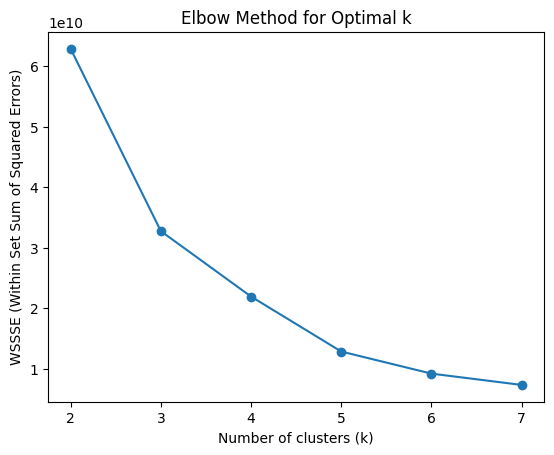

In [ ]:
# plotting elbow curve
plt.plot(range(2, 8), wssse_list, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WSSSE (Within Set Sum of Squared Errors)')
plt.title('Elbow Method for Optimal k')
plt.show()

In [ ]:
# Clustering using K-means
assembler = VectorAssembler(inputCols=["passenger_count", "trip_distance", "fare_amount", "total_amount",
                                      "payment_type", "trip_duration_seconds", "PULocationID", "DOLocationID",
                                      "pickup_hour", "pickup_minute", "pickup_second"], outputCol="features")
q3_df_data_features = assembler.transform(q3_df_data_clean)
optimal_k = 5
kmeans = KMeans(k=optimal_k, featuresCol="features", predictionCol="cluster")
model = kmeans.fit(q3_df_data_features)
predictions = model.transform(q3_df_data_features)
predictions.select("passenger_count", "trip_distance", "fare_amount", "total_amount", "payment_type",
                   "trip_duration_seconds", "PULocationID", "DOLocationID", "pickup_hour",
                   "pickup_minute", "pickup_second", "cluster").show(10)

+---------------+-------------+-----------+------------+------------+---------------------+------------+------------+-----------+-------------+-------------+-------+
|passenger_count|trip_distance|fare_amount|total_amount|payment_type|trip_duration_seconds|PULocationID|DOLocationID|pickup_hour|pickup_minute|pickup_second|cluster|
+---------------+-------------+-----------+------------+------------+---------------------+------------+------------+-----------+-------------+-------------+-------+
|              1|          0.5|        4.5|         5.8|           2|                  198|          41|          24|          0|           21|            5|      0|
|              1|          2.7|       14.0|        15.3|           2|                 1090|         239|         140|          0|           44|           55|      0|
|              2|          0.8|        6.0|         8.3|           1|                  355|         262|         141|          0|            8|           26|      0|
|   

The code segments passengers based on trip characteristics by applying K-means clustering. It first processes the data to extract relevant trip features like distance, fare, time, and payment type. Using the Elbow method, it determines the optimal number of clusters (k=5) to group similar trips. The final K-means model assigns each trip to a cluster based on these characteristics, effectively segmenting passengers into distinct groups, which can be used for targeted analysis or services based on trip patterns.

#### 4)Predict whether a passenger will pay by card or cash


In [ ]:
# Creating a function to get datetime information
def datetime_conversion(df, col, prefix):
    return df.withColumn(prefix+"_year", F.year(col)) \
             .withColumn(prefix+"_month", F.month(col)) \
             .withColumn(prefix+"_day", F.dayofmonth(col)) \
             .withColumn(prefix+"_hour", F.hour(col))\
             .withColumn(prefix+"_minute", F.minute(col)) \
             .withColumn(prefix+"_second", F.second(col)) \
             .withColumn(prefix+"_day_of_week", F.dayofweek(col))

In [ ]:
# Updating and filtering Dataframe
q4_df = merged_df
q4_df = datetime_conversion(q4_df, q4_df.tpep_pickup_datetime, "pickup")
q4_df = datetime_conversion(q4_df, q4_df.tpep_dropoff_datetime, "dropoff")
q4_df = q4_df.withColumn("trip_duration_seconds", F.unix_timestamp("tpep_dropoff_datetime") - F.unix_timestamp("tpep_pickup_datetime"))
q4_df = q4_df.filter((q4_df.payment_type == 1) | (q4_df.payment_type == 2))
q4_df.show(10)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+-----------+------------+----------+-----------+-------------+-------------+------------------+------------+-------------+-----------+------------+--------------+--------------+-------------------+---------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|pickup_year|pickup_month|pickup_day|pickup_hour|pickup_minute|pickup_second|pickup_day_of_week|dropoff_year|dropoff_month|dropoff_day|dropoff_hour|dropoff_minute|dropoff_second|dropoff_day_of_week|trip_duration_seconds|
+--------+----------

In [ ]:
# Filtering Dataframe
q4_df_data = q4_df.select(F.col("pickup_month"), F.col("pickup_day"), F.col("pickup_hour"), F.col("pickup_day_of_week"),
                          F.col("dropoff_month"), F.col("dropoff_day"), F.col("dropoff_hour"),
                          F.col("dropoff_day_of_week"), F.col("passenger_count"), F.col("trip_distance"),
                          F.col("fare_amount"), F.col("total_amount"), F.col("payment_type"),
                          F.col("PULocationID"), F.col("DOLocationID"), F.col("trip_duration_seconds"))
q4_df_data_clean = q4_df_data.dropna()
q4_df_data_clean.show(10)

+------------+----------+-----------+------------------+-------------+-----------+------------+-------------------+---------------+-------------+-----------+------------+------------+------------+------------+---------------------+
|pickup_month|pickup_day|pickup_hour|pickup_day_of_week|dropoff_month|dropoff_day|dropoff_hour|dropoff_day_of_week|passenger_count|trip_distance|fare_amount|total_amount|payment_type|PULocationID|DOLocationID|trip_duration_seconds|
+------------+----------+-----------+------------------+-------------+-----------+------------+-------------------+---------------+-------------+-----------+------------+------------+------------+------------+---------------------+
|           1|         1|          0|                 2|            1|          1|           0|                  2|              1|          0.5|        4.5|         5.8|           2|          41|          24|                  198|
|           1|         1|          0|                 2|            1|  

In [ ]:
# VectorAssembler
feature_columns_q4 = [
    "pickup_month", "pickup_day", "pickup_hour",
    "pickup_day_of_week", "dropoff_month", "dropoff_day",
    "dropoff_hour", "dropoff_day_of_week", "passenger_count",
    "trip_distance", "fare_amount", "PULocationID", "DOLocationID"
]
assembler_q4 = VectorAssembler(inputCols=feature_columns_q4, outputCol="features")
assembled_data = assembler_q4.transform(q4_df_data_clean)

In [ ]:
# Split the data into train and test sets
train_data, test_data = assembled_data.randomSplit([0.8, 0.2], seed=310)

In [ ]:
# Logistic regression
rf = RandomForestClassifier(featuresCol="features", labelCol="payment_type", numTrees=50)
rf_model = rf.fit(train_data)

In [ ]:
# Metrics
test_predictions = rf_model.transform(test_data)
f1_evaluator = MulticlassClassificationEvaluator(labelCol="payment_type", predictionCol="prediction", metricName="f1")
f1_score = f1_evaluator.evaluate(test_predictions)
print(f"Test F1 Score: {f1_score}")
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="payment_type", predictionCol="prediction", metricName="accuracy")
accuracy = accuracy_evaluator.evaluate(test_predictions)
print(f"Test Accuracy: {accuracy}")

Test F1 Score: 0.5906215599987846
Test Accuracy: 0.7032368224190594



The code uses a RandomForestClassifier to predict whether a passenger will pay by card or cash based on trip characteristics such as pickup and dropoff times, trip distance, fare, and passenger count. The model outputs a prediction of the payment type (card or cash) for each trip. The test results show an F1 score of 0.59 and an accuracy of 0.70, indicating the model's ability to correctly predict payment methods with moderate performance, though there is potential for improvement.